In [1]:
import os, sys
from models.backbones import get_model
from utils.data_utils import get_loaders
from utils.viz_utils import *

In [2]:
sys.path = list(dict.fromkeys(sys.path))  # reset path first
# paths relative to project root
PROJECT_ROOT = os.path.abspath("..")
os.chdir(PROJECT_ROOT)
sys.path.append(PROJECT_ROOT)

In [3]:
# directories
CHECKPOINTS_DIR = "saves/checkpoints"
LOGS_DIR = "saves/logs"
DATA_DIR = "data/splits"

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


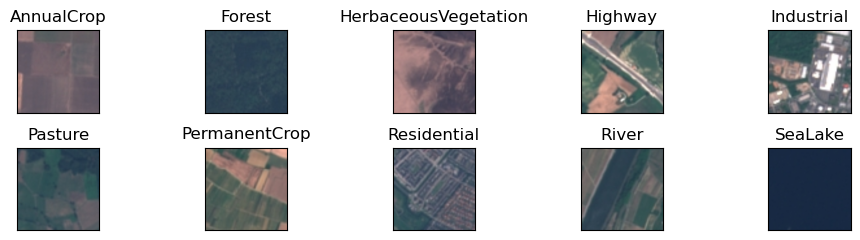

In [4]:
# data classes visualization
class_viz(DATA_DIR)

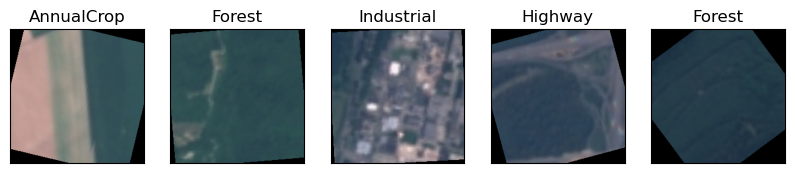

In [5]:
# train data visualization (with augmentations)
dataloaders = get_loaders(DATA_DIR, batch_size=5)
class_names = dataloaders['train'].dataset.classes

dataiter = iter(dataloaders['train'])
images, labels = next(dataiter)

fig, axes = plt.subplots(1, len(images), figsize=(10, 2.5))
for idx, image in enumerate(images):
    axes[idx].imshow(convert_to_imshow_format(image))
    axes[idx].set_title(class_names[labels[idx]])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

 Image Class: Highway


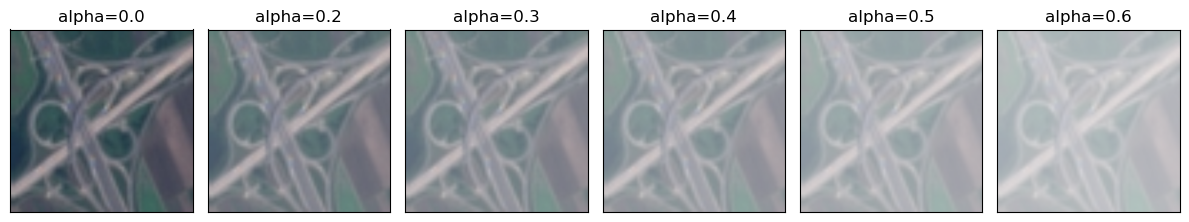

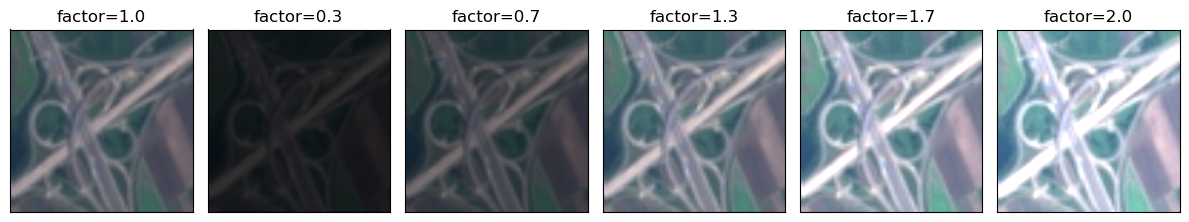

In [14]:
# data perturbations visualization

# getting one sample
dataloaders = get_loaders(DATA_DIR, batch_size=1)
class_names = dataloaders["test"].dataset.classes

test_iter = iter(dataloaders['test'])
image, label = next(test_iter)
image = denormalize_batch(image)
label = label.item()
print(f" Image Class: {class_names[label]}")
perturbations = ["Haze", "Brightness"]

# severity mappings (image-space)
HAZE_LEVELS = [0.0, 0.2, 0.3, 0.4, 0.5, 0.6]
BRIGHTNESS_LEVELS = [1.0, 0.3, 0.7, 1.3, 1.7, 2.0]

for perturbation in perturbations:
    # adding perturbation
    if perturbation == "Haze":
        noise_fn = add_haze
        severity = HAZE_LEVELS
        title = "alpha="
    else:
        noise_fn = adjust_brightness
        severity = BRIGHTNESS_LEVELS
        title = "factor="

    noisy_images = [noise_fn(image, s) for s in severity]

    fig, axes = plt.subplots(1, len(noisy_images), figsize=(12, 3))

    for idx, img in enumerate(noisy_images):
        axes[idx].imshow(to_imshow(img[0]))
        title_s = f"{title}{severity[idx]:.1f}"
        axes[idx].set_title(title_s)
        axes[idx].set_xticks([])
        axes[idx].set_yticks([])
    #fig.suptitle(f"Haze perturbation – class: {class_names[label]}", fontsize=14) # no plot title needed for the report (we added captions instead)
    plt.tight_layout()
    plt.show()



RESNET50: Grad CAM


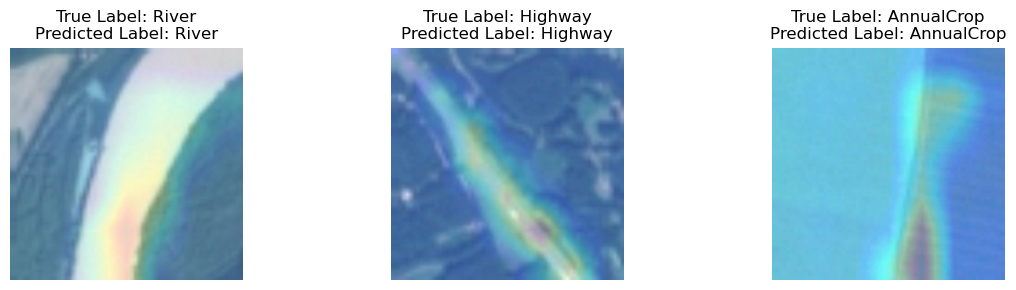


VIT_BASE: Attention Map


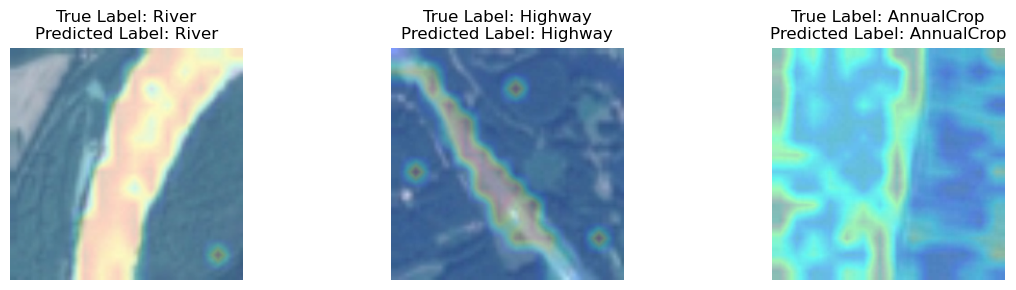


DINOV3: Attention Map


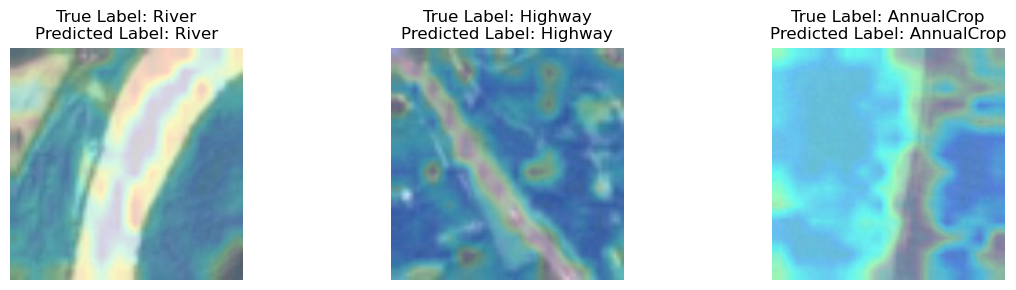

In [27]:
# Grad-CAMs and attention maps
model_list = ["resnet50", "vit_base", "dinov3"]

# images to test
dataloaders = get_loaders(DATA_DIR, batch_size=1)
class_names = dataloaders["test"].dataset.classes

test_iter = iter(dataloaders["test"])
images = []
labels = []

for _ in range(3):
    image, label = next(test_iter)
    images.append(image[0].to(device))   # remove batch dim
    labels.append(label.item())

for model_name in model_list:
    MODEL_CHECKPOINTS_DIR = os.path.join(CHECKPOINTS_DIR, f"BEST_{model_name}.pth")
    fine_tune = (model_name != "dinov3")
    model = get_model(model_name, num_classes=10, fine_tune=fine_tune).to(device)
    checkpoint = torch.load(MODEL_CHECKPOINTS_DIR, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint["model_state"])
    model.eval()

    heat_maps = []
    preds = []

    # get predictions first
    with torch.no_grad():
        for i in range(3):
            out = model(images[i].unsqueeze(0))
            preds.append(out.argmax(dim=1).item())

    # get visualizations
    if model_name == "resnet50":
        for i in range(3):
            heat_maps.append(gradcam(model, images[i].unsqueeze(0)))
        example_type = "Grad CAM"
    else:
        for i in range(3):
            heat_maps.append(attention_map(model, images[i].unsqueeze(0), model_name))
        example_type = "Attention Map"

    print(f"\n{model_name.upper()}: {example_type}")
    fig, axes = plt.subplots(1, 3, figsize=(12, 3))

    for idx in range(3):
        true_lbl = class_names[labels[idx]]
        pred_lbl = class_names[preds[idx]]
        axes[idx].imshow(heat_maps[idx])
        axes[idx].set_title(f"True Label: {true_lbl}\nPredicted Label: {pred_lbl}")
        axes[idx].axis("off")

    #fig.suptitle(f"{model_name.upper()}: {example_type}", fontsize=14) # no plot title needed for the report (we added captions instead)
    plt.tight_layout()
    plt.show()


In [8]:
# clean test accuracy
dataloaders = get_loaders(DATA_DIR, batch_size=32)
class_names = dataloaders["test"].dataset.classes

model_list = ["resnet50", "vit_base", "dinov3"]

for model_name in model_list:
    MODEL_CHECKPOINTS_DIR = os.path.join(CHECKPOINTS_DIR, f"BEST_{model_name}.pth")
    fine_tune = (model_name != "dinov3")
    model = get_model(model_name, num_classes=10, fine_tune=fine_tune).to(device)
    checkpoint = torch.load(MODEL_CHECKPOINTS_DIR, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint["model_state"])
    model.eval()

    clean_acc = evaluate(model=model, dataloader=dataloaders["test"], device=device, noise_fn=None, severity=0.0)
    print(f"\nModel: {model_name.upper()}")
    print(f"Clean Test Accuracy: {clean_acc:2f}%")



Model: RESNET50
Clean Test Accuracy: 98.296296%

Model: VIT_BASE
Clean Test Accuracy: 98.370370%

Model: DINOV3
Clean Test Accuracy: 95.481481%



Accuracy under Haze perturbation


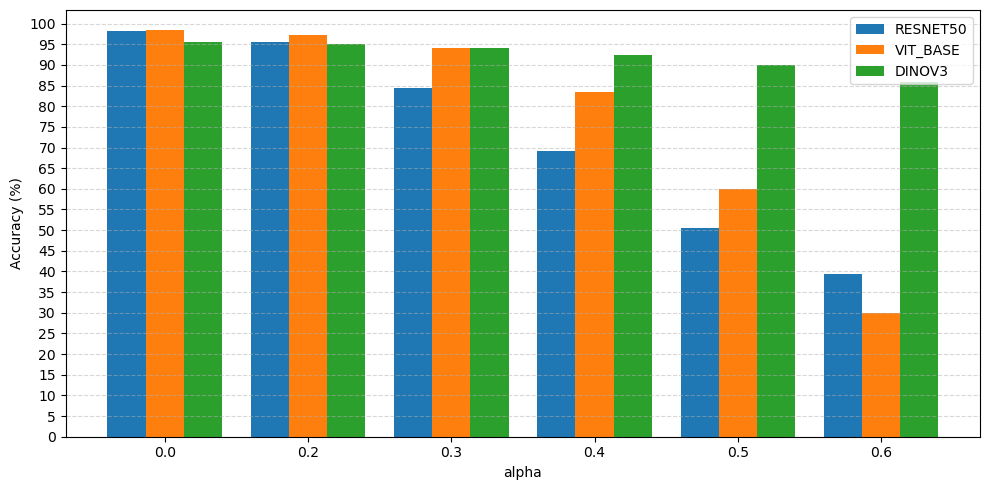


Accuracy under Brightness perturbation


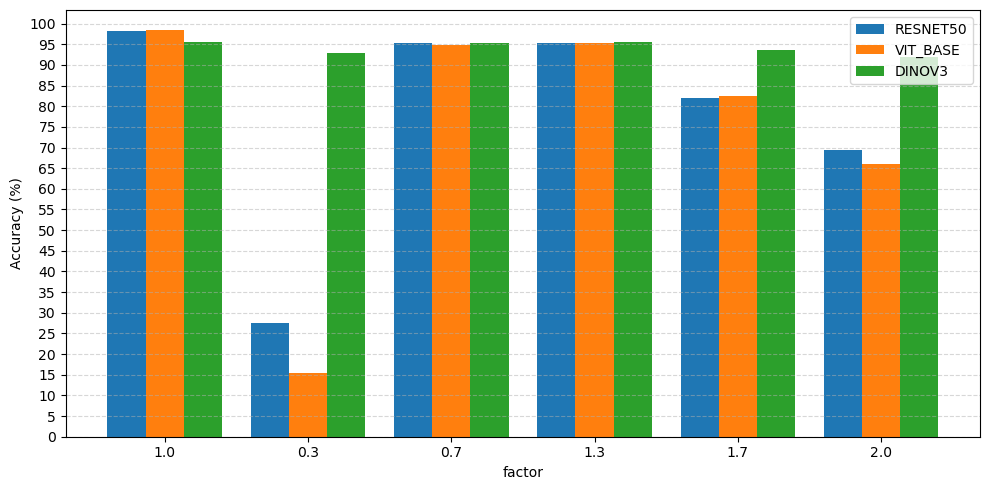

In [28]:
# models accuracy vs perturbation
dataloaders = get_loaders(DATA_DIR, batch_size=32)
class_names = dataloaders["test"].dataset.classes

model_list = ["resnet50", "vit_base", "dinov3"]
perturbations = ["Haze", "Brightness"]

# severity mappings (image-space)
HAZE_LEVELS = [0.0, 0.2, 0.3, 0.4, 0.5, 0.6]
BRIGHTNESS_LEVELS = [1.0, 0.3, 0.7, 1.3, 1.7, 2.0]

for perturbation in perturbations:
    acc_results = {}

    if perturbation == "Haze":
        noise_fn = add_haze
        severity = HAZE_LEVELS
        x_label = "alpha"

    else:
        noise_fn = adjust_brightness
        severity = BRIGHTNESS_LEVELS
        x_label = "factor"

    for model_name in model_list:
        MODEL_CHECKPOINTS_DIR = os.path.join(CHECKPOINTS_DIR, f"BEST_{model_name}.pth")
        fine_tune = (model_name != "dinov3")
        model = get_model(model_name, num_classes=10, fine_tune=fine_tune).to(device)
        checkpoint = torch.load(MODEL_CHECKPOINTS_DIR, map_location=device, weights_only=False)
        model.load_state_dict(checkpoint["model_state"])
        model.eval()

        acc_list = []
        for s in severity: # evaluating the model performance under the given perturbation severity
            acc = evaluate(model, dataloaders["test"], device, noise_fn, s)
            acc_list.append(acc)

        acc_results[model_name] = acc_list


    print(f"\nAccuracy under {perturbation} perturbation")
    plot_accuracy_vs_severity(acc_dict=acc_results, perturbation_name=perturbation, x_label=x_label, x_values=severity)
